# Grover's Search Algorithm

### Imports Library

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import display, Latex
%matplotlib inline

In [2]:
from qiskit import QuantumCircuit,QuantumRegister,execute, ClassicalRegister, transpile, Aer, IBMQ
from qiskit import visualization 
from qiskit.tools import jupyter as qjupyter 

In [3]:
from qiskit import assemble

# Clasical Search Demo : Linear Search

In [4]:
list1=[1,2,5,9,2,0,6,3,7,15,4,13,8,12]
def the_oracle(search_item):
    winner=7
    if search_item == winner:
        return True
    return False

In [5]:
for index , tryal_no in enumerate(list1):
    if the_oracle(tryal_no):
        print(f"Item Found at index{index}")
        print(f"No of Oracle Call is {index+1}")
        break
              

Item Found at index8
No of Oracle Call is 9


## Quantum Way to search an Oracle : **Grover Search Algorithm**

### Define Required Functions

In [6]:
# Converting  into binary representation
to_bin= (lambda a,size=4 : np.array([int(i) for i in np.binary_repr(a,size)]))
to_bin(14,8)

array([0, 0, 0, 0, 1, 1, 1, 0])

our oracle function will be $U_w |x\rangle  |y\rangle = |y \oplus f(x) \rangle$

$f(x)= 1$ for $x = w$ and  $f(x)=0$ for $x\neq w$ 

In [7]:
def get_oracle(n, w)->QuantumCircuit:
    circuit = QuantumCircuit(n+1, name="oracle")
    controled0 = np.array([i for i in  range(n) if not w[i]])
    if controled0.size>0:
        circuit.x(controled0)
    circuit.mct(list(range(n)), n)
    if controled0.size>0:
        circuit.x(controled0)
    circuit.barrier()
   
    return circuit

In [8]:
def reflect_uniform(circuit, n):
    circuit.h(list(range(n)))
    circuit.x(list(range(n)))
    circuit.mct(list(range(n)),n)
    circuit.x(list(range(n+1)))    
    circuit.h(list(range(n)))
    circuit.barrier()
    circuit.draw()  

In [9]:
def get_projection(psi, e,a ):
    return (np.real(np.vdot(e,psi)), np.real(np.vdot(a,psi)))

def plot_vector(proj,axis = [0.0,1.0,0.0,1.0]):
    x_pos = y_pos = 0
    x_direct,y_direct = proj
    
    # Creating Plot 
    fig,ax=plt.subplots()
    ax.quiver(x_pos,y_pos,x_direct, y_direct, scale =1.0)
    ax.axis(axis)
    
    plt.show()

### Building Grover Circuit 

In [10]:
element = 13 # Element To Find out
n = 4  # n qubit System 
w = np.flip(to_bin(element,n)) #  1101[13(decimal)] element is mrked (lsb to msb)
w # Binary Representation of Element ( reversed )

array([1, 0, 1, 1])

In [11]:
# Define Quantum Register 
qr = QuantumRegister(n,name="q")
qr2 = QuantumRegister(1,name="x")
## Classical Register 
cr = ClassicalRegister(n,"c")
## Define Circuit
circuit = QuantumCircuit(qr,qr2,cr)
## Appling X-gate on 'x'
circuit.x(n)
circuit.barrier()
## Appling Hadamard on 4 qubits 'q_i'
circuit.h(list(range(n+1)))
# grover_circuit.barrier()
circuit.draw()


░ ┌───┐
q_0: ──────░─┤ H ├
           ░ ├───┤
q_1: ──────░─┤ H ├
           ░ ├───┤
q_2: ──────░─┤ H ├
           ░ ├───┤
q_3: ──────░─┤ H ├
     ┌───┐ ░ ├───┤
  x: ┤ X ├─░─┤ H ├
     └───┘ ░ └───┘
c: 4/═════════════

#### Executing and get state vectors

In [12]:
state_vector_simulator = Aer.get_backend('statevector_simulator')
result = execute(circuit,state_vector_simulator).result()
state_vector = result.data()['statevector']
state_vector = state_vector.data[:2**n]
init_state_vector = state_vector

#### Plotting state vector 

In [13]:
ket_a = np.zeros(2**n)
ket_a[element]=1
ket_e = (np.ones(2**n)-ket_a)/(2**n-1)**.5
ket_a

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

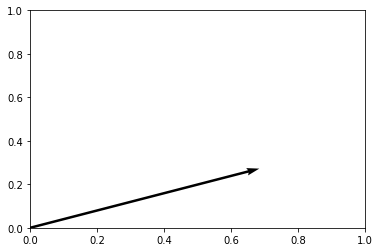

In [14]:
plot_vector(get_projection(state_vector,ket_e,ket_a))

In [15]:
display(get_projection(state_vector,ket_e,ket_a))
circuit.append(get_oracle(n,w),range(n+1))
reflect_uniform(circuit,n)
circuit.draw()


(0.6846531968814575, 0.17677669529663684)

░ ┌───┐┌─────────┐┌───┐┌───┐     ┌───┐┌───┐ ░ 
q_0: ──────░─┤ H ├┤0        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ 
q_1: ──────░─┤ H ├┤1        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ 
q_2: ──────░─┤ H ├┤2 oracle ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ 
q_3: ──────░─┤ H ├┤3        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─
     ┌───┐ ░ ├───┤│         │└───┘└───┘┌─┴─┐├───┤└───┘ ░ 
  x: ┤ X ├─░─┤ H ├┤4        ├──────────┤ X ├┤ X ├──────░─
     └───┘ ░ └───┘└─────────┘          └───┘└───┘      ░ 
c: 4/════════════════════════════════════════════════════

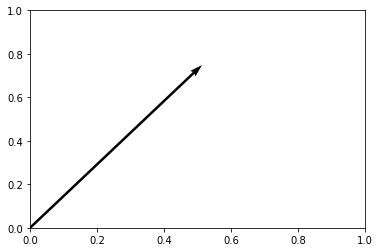

In [16]:
# Running Circuit
result = execute(circuit,state_vector_simulator).result()
state_vector = result.data()['statevector']
state_vector = state_vector.data[:2**n]

# Plot state vector
plot_vector(get_projection(state_vector,ket_e,ket_a))

In [17]:
circuit.append(get_oracle(n,w), range(n+1))
reflect_uniform(circuit,n)
circuit.draw()

░ ┌───┐┌─────────┐┌───┐┌───┐     ┌───┐┌───┐ ░ ┌─────────┐┌───┐┌───┐»
q_0: ──────░─┤ H ├┤0        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤0        ├┤ H ├┤ X ├»
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ │         │├───┤├───┤»
q_1: ──────░─┤ H ├┤1        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤1        ├┤ H ├┤ X ├»
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ │         │├───┤├───┤»
q_2: ──────░─┤ H ├┤2 oracle ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤2 oracle ├┤ H ├┤ X ├»
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ │         │├───┤├───┤»
q_3: ──────░─┤ H ├┤3        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤3        ├┤ H ├┤ X ├»
     ┌───┐ ░ ├───┤│         │└───┘└───┘┌─┴─┐├───┤└───┘ ░ │         │└───┘└───┘»
  x: ┤ X ├─░─┤ H ├┤4        ├──────────┤ X ├┤ X ├──────░─┤4        ├──────────»
     └───┘ ░ └───┘└─────────┘          └───┘└───┘      ░ └─────────┘          »
c: 4/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«          ┌───┐┌───┐ ░ 
«q_0: ──■──┤ X ├┤ H ├─░─
«       │  ├───┤├───┤ ░ 
«q_1: ──■──┤ X ├┤ H ├─░─
«       │  ├───┤├───┤ ░ 
«q_2: ──■──┤ X ├┤ H ├─░─
«       │  ├───┤├───┤ ░ 
«q_3: ──■──┤ X ├┤ H ├─░─
«     ┌─┴─┐├───┤└───┘ ░ 
«  x: ┤ X ├┤ X ├──────░─
«     └───┘└───┘      ░ 
«c: 4/══════════════════
«

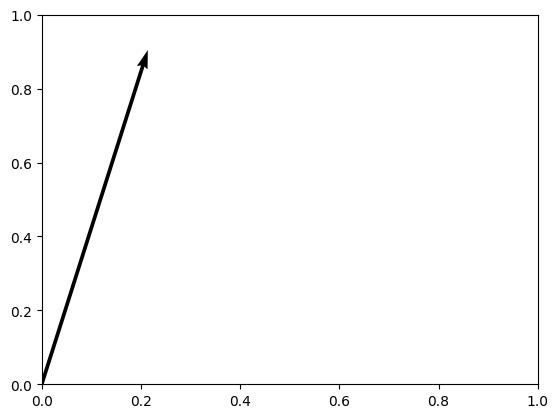

In [63]:
# Running Circuit
result = execute(circuit,state_vector_simulator).result()
state_vector = result.data()['statevector']
state_vector = state_vector.data[:2**n]

# Plot state vector
plot_vector(get_projection(state_vector,ket_e,ket_a))

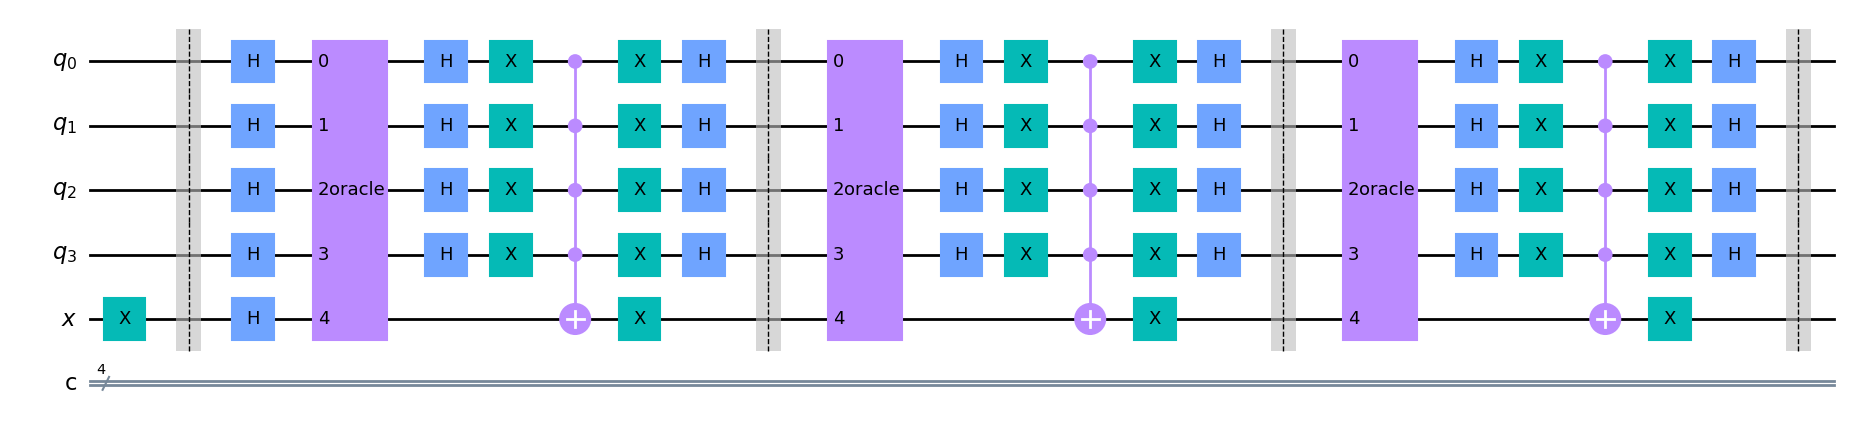

In [64]:
circuit.append(get_oracle(n,w),range(n+1))
reflect_uniform(circuit,n)
circuit.draw(fold=False)

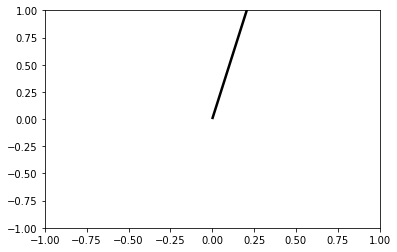

In [20]:
# Running Circuit

result = execute(circuit,state_vector_simulator).result()
state_vector = result.data()['statevector']
state_vector = state_vector.data[:2**n]

# Plot state vector
plot_vector(get_projection(state_vector,ket_e,ket_a), axis=[-1.0,1.0,-1.0,1.0])

## Determine the no of iteration to reflect the state vectors 

In [21]:
slope = get_projection( init_state_vector , ket_e, ket_a)
slope=slope[1]/slope[0]
theta0=np.arctan(slope)
display(Latex('${\\theta}_0=$%f radian'%theta0 ))
theta0*180/np.pi
display(Latex('${\\theta}_0=$%f degree'%(theta0*180/np.pi) ))
# (2T+1)theta0 < pi/2
T = (np.pi/(2*theta0)-1)/2
T

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

2.6082688394304085

## Create circuit for real computer 

In [23]:
# numbr of qubit
n = 4           
# searching element 
element = 13    # 0 to 15

qr = QuantumRegister(n,name="q")
qr2 = QuantumRegister(1,"y")

cr = ClassicalRegister(n,"c")
grover_circuit = QuantumCircuit(qr,qr2,cr)

w = np.flip(to_bin(element)) 

grover_circuit.x(n)
grover_circuit.barrier()
grover_circuit.h(list(range(n+1)))


for i in range(int(np.floor(T))):
    grover_circuit.append(get_oracle(n, w),range(n+1))
    reflect_uniform(grover_circuit, n)
    
for j in range(n):
    
    grover_circuit.measure(j,j)
     
grover_circuit.draw(fold=False)

░ ┌───┐┌─────────┐┌───┐┌───┐     ┌───┐┌───┐ ░ ┌─────────┐┌───┐┌───┐»
q_0: ──────░─┤ H ├┤0        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤0        ├┤ H ├┤ X ├»
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ │         │├───┤├───┤»
q_1: ──────░─┤ H ├┤1        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤1        ├┤ H ├┤ X ├»
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ │         │├───┤├───┤»
q_2: ──────░─┤ H ├┤2 oracle ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤2 oracle ├┤ H ├┤ X ├»
           ░ ├───┤│         │├───┤├───┤  │  ├───┤├───┤ ░ │         │├───┤├───┤»
q_3: ──────░─┤ H ├┤3        ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─┤3        ├┤ H ├┤ X ├»
     ┌───┐ ░ ├───┤│         │└───┘└───┘┌─┴─┐├───┤└───┘ ░ │         │└───┘└───┘»
  y: ┤ X ├─░─┤ H ├┤4        ├──────────┤ X ├┤ X ├──────░─┤4        ├──────────»
     └───┘ ░ └───┘└─────────┘          └───┘└───┘      ░ └─────────┘          »
c: 4/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«          ┌───┐┌───┐ ░ ┌─┐         
«q_0: ──■──┤ X ├┤ H ├─░─┤M├─────────
«       │  ├───┤├───┤ ░ └╥┘┌─┐      
«q_1: ──■──┤ X ├┤ H ├─░──╫─┤M├──────
«       │  ├───┤├───┤ ░  ║ └╥┘┌─┐   
«q_2: ──■──┤ X ├┤ H ├─░──╫──╫─┤M├───
«       │  ├───┤├───┤ ░  ║  ║ └╥┘┌─┐
«q_3: ──■──┤ X ├┤ H ├─░──╫──╫──╫─┤M├
«     ┌─┴─┐├───┤└───┘ ░  ║  ║  ║ └╥┘
«  y: ┤ X ├┤ X ├──────░──╫──╫──╫──╫─
«     └───┘└───┘      ░  ║  ║  ║  ║ 
«c: 4/═══════════════════╩══╩══╩══╩═
«                        0  1  2  3

In [24]:
qasm_simulator = Aer.get_backend("qasm_simulator")
result = execute(grover_circuit,qasm_simulator).result()
counts = result.get_counts(grover_circuit)

counts

{'0100': 6,
 '1100': 4,
 '0001': 4,
 '1101': 933,
 '1011': 7,
 '0011': 5,
 '0111': 8,
 '1010': 9,
 '1111': 7,
 '1110': 5,
 '0000': 8,
 '0010': 6,
 '0110': 5,
 '1000': 8,
 '0101': 6,
 '1001': 3}

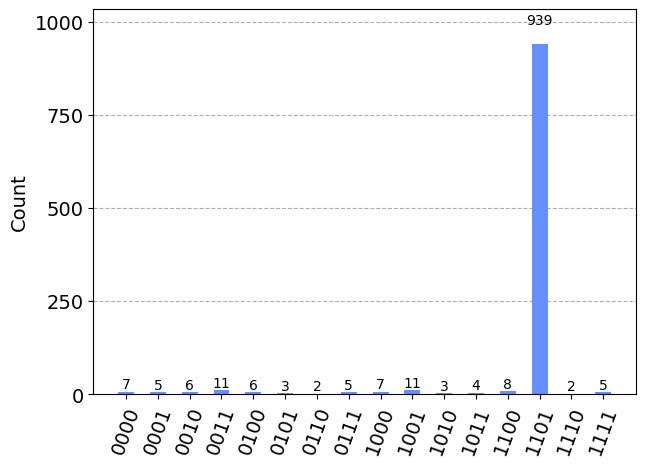

In [69]:
visualization.plot_histogram(counts)